# Data importation and vizualisation

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')
df = pd.concat([X, y], axis=1)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


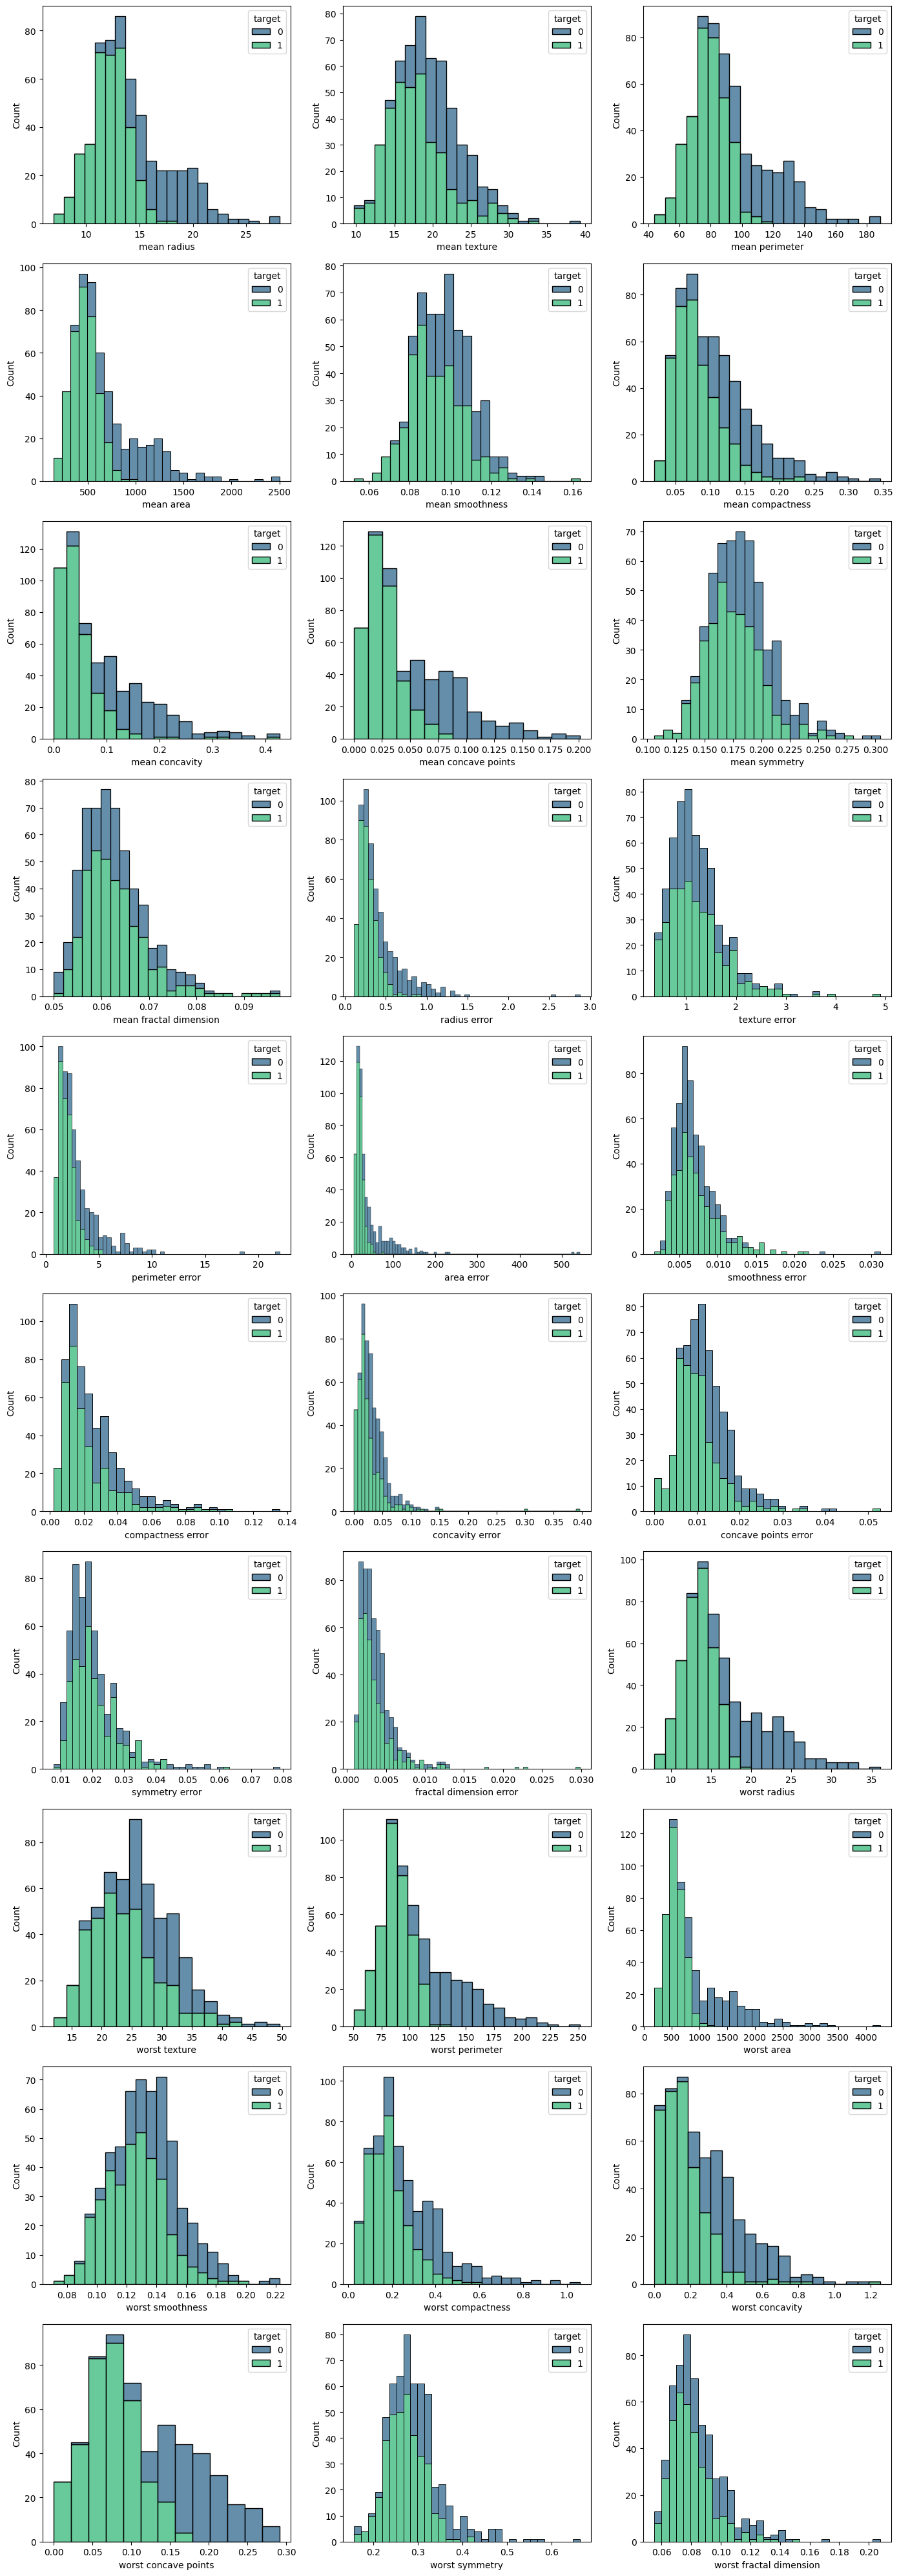

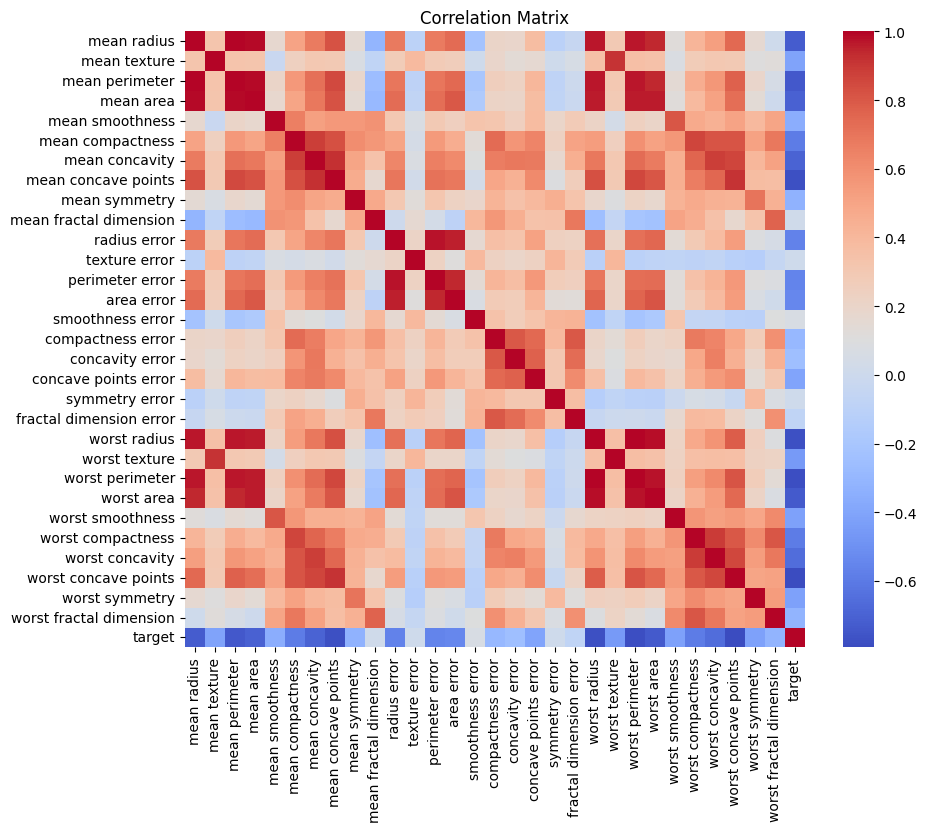

In [ ]:
# Load data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')
df = pd.concat([X, y], axis=1)

# Visualization of distributions of each characteristic
def plot_feature_distributions(df, features):
    fig, axs = plt.subplots(nrows=len(features) // 3, ncols=3, figsize=(14, 4 * (len(features) // 3)))
    for i, feature in enumerate(features):
        row = i // 3
        col = i % 3
        sns.histplot(df, x=feature, hue="target", multiple="stack", ax=axs[row, col], palette="viridis")
    plt.tight_layout()
    plt.show()

plot_feature_distributions(df, data.feature_names)

# Correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Data preprocessing

In [ ]:
# Load data
data = load_breast_cancer()
X = data.data
y = data.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Transform labels: from 0,1 to -1,1
y = np.where(y == 0, -1, 1)


# Impelementation of Svm Classifier on the  breast cancer dataset

# Using a linear kernel on this Svm

In [ ]:
class SMOSVM:
    def __init__(self, C=1.0, tol=0.01, max_passes=5, kernel='linear'):
        self.C = C
        self.tol = tol
        self.max_passes = max_passes
        self.kernel = kernel
        self.alphas = None
        self.b = 0
        self.X_train = None
        self.y_train = None

    def linear_kernel(self, x1, x2):
        return np.dot(x1, x2)

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        n_samples, n_features = X.shape
        self.alphas = np.zeros(n_samples)
        passes = 0

        while passes < self.max_passes:
            num_changed_alphas = 0
            for i in range(n_samples):
                prediction = self.predict(self.X_train[i].reshape(1, -1))
                E_i = prediction - y[i]

                if (y[i] * E_i < -self.tol and self.alphas[i] < self.C) or (y[i] * E_i > self.tol and self.alphas[i] > 0):
                    j = np.random.choice([n for n in range(n_samples) if n != i])
                    prediction_j = self.predict(self.X_train[j].reshape(1, -1))
                    E_j = prediction_j - y[j]

                    alpha_i_old, alpha_j_old = self.alphas[i], self.alphas[j]

                    if y[i] != y[j]:
                        L = max(0, self.alphas[j] - self.alphas[i])
                        H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
                    else:
                        L = max(0, self.alphas[i] + self.alphas[j] - self.C)
                        H = min(self.C, self.alphas[i] + self.alphas[j])

                    if L == H:
                        continue

                    eta = 2 * self.linear_kernel(self.X_train[i], self.X_train[j]) - self.linear_kernel(self.X_train[i], self.X_train[i]) - self.linear_kernel(self.X_train[j], self.X_train[j])
                    if eta >= 0:
                        continue

                    self.alphas[j] -= (y[j] * (E_i - E_j)) / eta
                    self.alphas[j] = max(L, min(H, self.alphas[j]))

                    if abs(self.alphas[j] - alpha_j_old) < 0.00001:
                        continue

                    self.alphas[i] += y[i] * y[j] * (alpha_j_old - self.alphas[j])

                    b1 = self.b - E_i - y[i] * (self.alphas[i] - alpha_i_old) * self.linear_kernel(self.X_train[i], self.X_train[i]) - y[j] * (self.alphas[j] - alpha_j_old) * self.linear_kernel(self.X_train[i], self.X_train[j])
                    b2 = self.b - E_j - y[i] * (self.alphas[i] - alpha_i_old) * self.linear_kernel(self.X_train[i], self.X_train[j]) - y[j] * (self.alphas[j] - alpha_j_old) * self.linear_kernel(self.X_train[j], self.X_train[j])

                    if 0 < self.alphas[i] < self.C:
                        self.b = b1
                    elif 0 < self.alphas[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2.0

                    num_changed_alphas += 1

            if num_changed_alphas == 0:
                passes += 1
            else:
                passes = 0

    def predict(self, X):
        f_x = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            sum_term = np.dot((self.alphas * self.y_train), self.X_train.dot(X[i].T))
            f_x[i] = sum_term + self.b
        return np.sign(f_x)

In [ ]:
X = data.data
y = data.target
# Transform labels from 0,1 to -1,1
y = np.where(y == 0, -1, 1)

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate SVM
svm = SMOSVM(C=1.0, tol=0.01, max_passes=5)
svm.fit(X_train_scaled, y_train)
predictions = svm.predict(X_test_scaled)
linear_kernel_accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy using SMO SVC with linear kernel: {linear_kernel_accuracy:.4f}')

<ipython-input-21-54433bd882f3>:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.alphas[j] -= (y[j] * (E_i - E_j)) / eta
<ipython-input-21-54433bd882f3>:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f_x[i] = sum_term + self.b


Accuracy using SMO SVC with linear kernel: 0.9825


# Using a polynomial Kernel (degrees from 1 to 3)

In [ ]:
class SMOSVM_polynomial_kernel:
    def __init__(self, C=1.0, tol=0.01, max_passes=5, kernel='linear', degree=3, gamma=1, r=0):
        self.C = C
        self.tol = tol
        self.max_passes = max_passes
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.r = r
        self.alphas = None
        self.b = 0
        self.X_train = None
        self.y_train = None

    def polynomial_kernel(self, x1, x2):
        return (self.gamma * np.dot(x1, x2) + self.r) ** self.degree

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        n_samples, n_features = X.shape
        self.alphas = np.zeros(n_samples)
        passes = 0

        while passes < self.max_passes:
            num_changed_alphas = 0
            for i in range(n_samples):
                prediction = self.predict(X[i].reshape(1, -1))
                E_i = prediction - y[i]

                if (y[i] * E_i < -self.tol and self.alphas[i] < self.C) or (y[i] * E_i > self.tol and self.alphas[i] > 0):
                    j = np.random.choice([n for n in range(n_samples) if n != i])
                    prediction_j = self.predict(X[j].reshape(1, -1))
                    E_j = prediction_j - y[j]

                    alpha_i_old, alpha_j_old = self.alphas[i], self.alphas[j]

                    if y[i] != y[j]:
                        L = max(0, self.alphas[j] - self.alphas[i])
                        H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
                    else:
                        L = max(0, self.alphas[i] + self.alphas[j] - self.C)
                        H = min(self.C, self.alphas[i] + self.alphas[j])

                    if L == H:
                        continue

                    eta = 2 * self.polynomial_kernel(X[i], X[j]) - self.polynomial_kernel(X[i], X[i]) - self.polynomial_kernel(X[j], X[j])
                    if eta >= 0:
                        continue

                    self.alphas[j] -= (y[j] * (E_i - E_j)) / eta
                    self.alphas[j] = max(L, min(H, self.alphas[j]))

                    if abs(self.alphas[j] - alpha_j_old) < 0.00001:
                        continue

                    self.alphas[i] += y[i] * y[j] * (alpha_j_old - self.alphas[j])

                    b1 = self.b - E_i - y[i] * (self.alphas[i] - alpha_i_old) * self.polynomial_kernel(X[i], X[i]) - y[j] * (self.alphas[j] - alpha_j_old) * self.polynomial_kernel(X[i], X[j])
                    b2 = self.b - E_j - y[i] * (self.alphas[i] - alpha_i_old) * self.polynomial_kernel(X[i], X[j]) - y[j] * (self.alphas[j] - alpha_j_old) * self.polynomial_kernel(X[j], X[j])

                    if 0 < self.alphas[i] < self.C:
                        self.b = b1
                    elif 0 < self.alphas[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2.0

                    num_changed_alphas += 1

            if num_changed_alphas == 0:
                passes += 1
            else:
                passes = 0

    def predict(self, X):
        f_x = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            sum_term = np.sum([self.alphas[j] * self.y_train[j] * self.polynomial_kernel(X[i], self.X_train[j])
                               for j in range(self.X_train.shape[0])])
            f_x[i] = sum_term + self.b
        return np.sign(f_x)

In [ ]:
# Define a list of degrees to test
degrees_to_test = [1, 2, 3]

# Initialize a dictionary to store accuracies for each degree
degree_accuracies = {}

# Loop over each degree
for degree in degrees_to_test:
    # Initialize SVM with the specified degree
    svm = SMOSVM_polynomial_kernel(C=1.0, tol=0.01, max_passes=5, kernel='polynomial', degree=degree)
    # Train the SVM
    svm.fit(X_train_scaled, y_train)
    # Make predictions
    predictions = svm.predict(X_test_scaled)
    # Calculate accuracy
    accuracy = np.mean(predictions == y_test)
    # Store the accuracy for this degree
    degree_accuracies[degree] = accuracy
    print(f"Degree: {degree}, Accuracy: {accuracy:.4f}")

<ipython-input-23-680b66bb45a7>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.alphas[j] -= (y[j] * (E_i - E_j)) / eta
<ipython-input-23-680b66bb45a7>:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f_x[i] = sum_term + self.b


Degree: 1, Accuracy: 0.9942
Degree: 2, Accuracy: 0.8480
Degree: 3, Accuracy: 0.9766


# Using Sigmoid Kernel

In [ ]:
class SMOSVM_sigmoid_kernel:
    def __init__(self, C=1.0, tol=0.01, max_passes=5, kernel='sigmoid', degree=3, gamma=1, r=0):
        self.C = C
        self.tol = tol
        self.max_passes = max_passes
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.r = r
        self.alphas = None
        self.b = 0
        self.X_train = None
        self.y_train = None

    def sigmoid_kernel(self, x1, x2):
        return np.tanh(self.gamma * np.dot(x1, x2) + self.r)

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        n_samples, n_features = X.shape
        self.alphas = np.zeros(n_samples)
        passes = 0

        while passes < self.max_passes:
            num_changed_alphas = 0
            for i in range(n_samples):
                E_i = self.predict(X[i].reshape(1, -1)) - y[i]

                if (y[i] * E_i < -self.tol and self.alphas[i] < self.C) or (y[i] * E_i > self.tol and self.alphas[i] > 0):
                    j = np.random.choice([n for n in range(n_samples) if n != i])
                    E_j = self.predict(X[j].reshape(1, -1)) - y[j]

                    alpha_i_old, alpha_j_old = self.alphas[i], self.alphas[j]

                    if y[i] != y[j]:
                        L = max(0, self.alphas[j] - self.alphas[i])
                        H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
                    else:
                        L = max(0, self.alphas[i] + self.alphas[j] - self.C)
                        H = min(self.C, self.alphas[i] + self.alphas[j])

                    if L == H:
                        continue

                    eta = 2 * self.sigmoid_kernel(X[i], X[j]) - self.sigmoid_kernel(X[i], X[i]) - self.sigmoid_kernel(X[j], X[j])
                    if eta >= 0:
                        continue

                    self.alphas[j] -= (y[j] * (E_i - E_j)) / eta
                    self.alphas[j] = max(L, min(H, self.alphas[j]))

                    if abs(self.alphas[j] - alpha_j_old) < 0.00001:
                        continue

                    self.alphas[i] += y[i] * y[j] * (alpha_j_old - self.alphas[j])

                    b1 = self.b - E_i - y[i] * (self.alphas[i] - alpha_i_old) * self.sigmoid_kernel(X[i], X[i]) - y[j] * (self.alphas[j] - alpha_j_old) * self.sigmoid_kernel(X[i], X[j])
                    b2 = self.b - E_j - y[i] * (self.alphas[i] - alpha_i_old) * self.sigmoid_kernel(X[i], X[j]) - y[j] * (self.alphas[j] - alpha_j_old) * self.sigmoid_kernel(X[j], X[j])

                    if 0 < self.alphas[i] < self.C:
                        self.b = b1
                    elif 0 < self.alphas[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2.0

                    num_changed_alphas += 1

            if num_changed_alphas == 0:
                passes += 1
            else:
                passes = 0

    def predict(self, X):
        f_x = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            sum_term = np.dot((self.alphas * self.y_train), self.X_train.dot(X[i].T))
            f_x[i] = sum_term + self.b
        return np.sign(f_x)

In [ ]:
svm = SMOSVM_sigmoid_kernel(C=1.0, tol=0.01, max_passes=5, kernel='sigmoid')
svm.fit(X_train_scaled, y_train)
predictions = svm.predict(X_test_scaled)
sigmoid_kernel_accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy with sigmoid kernel: {sigmoid_kernel_accuracy:.4f}')

<ipython-input-25-72054022dda8>:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.alphas[j] -= (y[j] * (E_i - E_j)) / eta
<ipython-input-25-72054022dda8>:79: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f_x[i] = sum_term + self.b


Accuracy with sigmoid kernel: 0.9708


# Using Gaussian Kernel

In [ ]:
class SMOSVM_gaussian_kernel:
    def __init__(self, C=1.0, tol=0.01, max_passes=5, kernel='rbf', gamma=0.5):
        self.C = C
        self.tol = tol
        self.max_passes = max_passes
        self.kernel = kernel
        self.gamma = gamma
        self.alphas = None
        self.b = 0
        self.X_train = None
        self.y_train = None

    def rbf_kernel(self, x1, x2):
        return np.exp((-0.5*(self.gamma)**-2) * np.linalg.norm(x1 - x2)**2)

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        n_samples, n_features = X.shape
        self.alphas = np.zeros(n_samples)
        passes = 0

        while passes < self.max_passes:
            num_changed_alphas = 0
            for i in range(n_samples):
                E_i = self.predict(X[i].reshape(1, -1)) - y[i]

                if (y[i]*E_i < -self.tol and self.alphas[i] < self.C) or (y[i]*E_i > self.tol and self.alphas[i] > 0):
                    j = np.random.choice([n for n in range(n_samples) if n != i])
                    E_j = self.predict(X[j].reshape(1, -1)) - y[j]

                    alpha_i_old, alpha_j_old = self.alphas[i], self.alphas[j]

                    if y[i] != y[j]:
                        L = max(0, self.alphas[j] - self.alphas[i])
                        H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
                    else:
                        L = max(0, self.alphas[i] + self.alphas[j] - self.C)
                        H = min(self.C, self.alphas[i] + self.alphas[j])

                    if L == H:
                        continue

                    eta = 2 * self.rbf_kernel(X[i], X[j]) - self.rbf_kernel(X[i], X[i]) - self.rbf_kernel(X[j], X[j])
                    if eta >= 0:
                        continue

                    self.alphas[j] -= (y[j] * (E_i - E_j)) / eta
                    self.alphas[j] = max(L, min(H, self.alphas[j]))

                    if abs(self.alphas[j] - alpha_j_old) < 0.00001:
                        continue

                    self.alphas[i] += y[i] * y[j] * (alpha_j_old - self.alphas[j])

                    b1 = self.b - E_i - y[i] * (self.alphas[i] - alpha_i_old) * self.rbf_kernel(X[i], X[i]) - y[j] * (self.alphas[j] - alpha_j_old) * self.rbf_kernel(X[i], X[j])
                    b2 = self.b - E_j - y[i] * (self.alphas[i] - alpha_i_old) * self.rbf_kernel(X[i], X[j]) - y[j] * (self.alphas[j] - alpha_j_old) * self.rbf_kernel(X[j], X[j])

                    if 0 < self.alphas[i] < self.C:
                        self.b = b1
                    elif 0 < self.alphas[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2.0

                    num_changed_alphas += 1

            if num_changed_alphas == 0:
                passes += 1
            else:
                passes = 0

    def predict(self, X):
        f_x = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            sum_term = sum(self.alphas[j] * self.y_train[j] * self.rbf_kernel(X[i], self.X_train[j]) for j in range(self.X_train.shape[0]))
            f_x[i] = sum_term + self.b
        return np.sign(f_x)

In [ ]:
X = data.data
y = data.target
y = np.where(y == 0, -1, 1)  # Transform labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SMOSVM_gaussian_kernel(C=1.0, tol=0.01, max_passes=5, kernel='rbf', gamma=0.5)
svm.fit(X_train_scaled, y_train)
predictions = svm.predict(X_test_scaled)
Gaussian_kernel_accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.4f}')

<ipython-input-27-629faf6cd499>:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.alphas[j] -= (y[j] * (E_i - E_j)) / eta
<ipython-input-27-629faf6cd499>:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f_x[i] = sum_term + self.b


Accuracy: 0.9766


# A Comparative Visualization between each Kernel used in this project

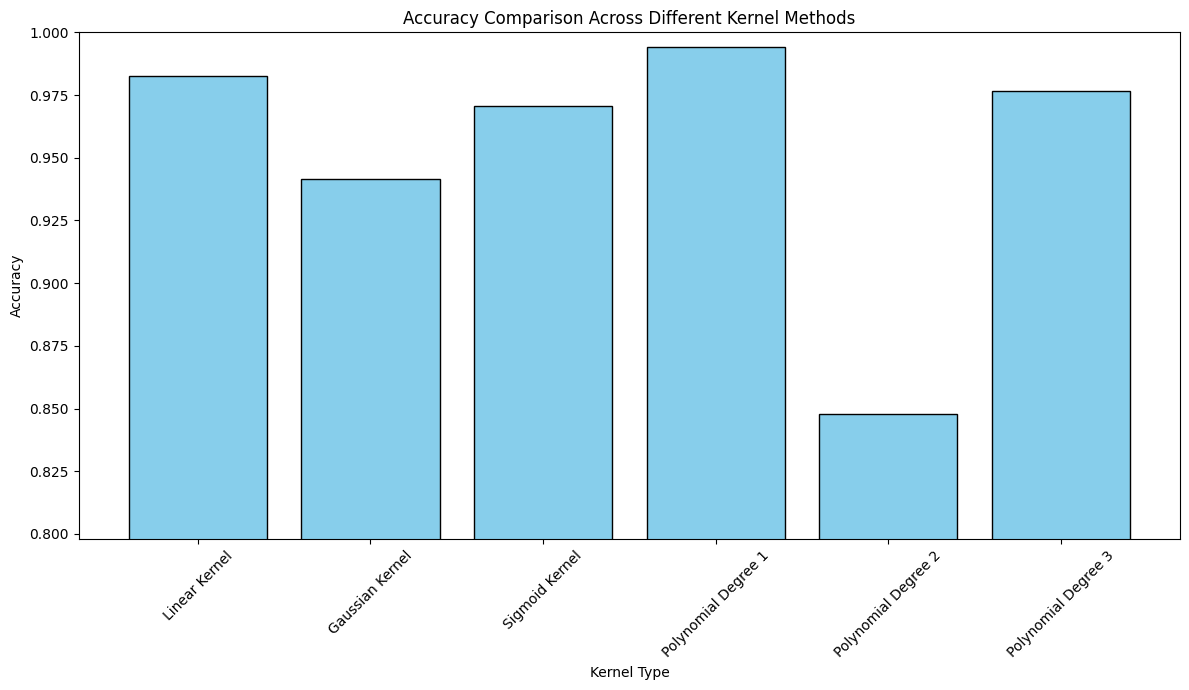

In [ ]:
kernel_names = ['Linear Kernel', 'Gaussian Kernel', 'Sigmoid Kernel'] + [f'Polynomial Degree {d}' for d in sorted(degree_accuracies.keys())]
accuracies = [linear_kernel_accuracy, Gaussian_kernel_accuracy, sigmoid_kernel_accuracy] + [degree_accuracies[d] for d in sorted(degree_accuracies.keys())]
plt.figure(figsize=(12, 7))
positions = np.arange(len(kernel_names))
plt.bar(positions, accuracies, color='skyblue', edgecolor='black')
plt.xlabel('Kernel Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Different Kernel Methods')
plt.xticks(positions, kernel_names, rotation=45)
plt.ylim(min(accuracies) - 0.05, 1)
plt.tight_layout()
plt.show()